#### 1.1 Simulation

In [1]:
import numpy as np
from scipy.integrate import odeint

def pendulum_rhs(zt, dzt, coefficients, terms):
    theta = np.array([term(zt, dzt) for term in terms]).T
    # Compute the scalar product
    return np.dot(theta, coefficients)

def pendulum_ode_step(y, t, coefficients, terms):
    z, dz = y
    ddz = pendulum_rhs(z, dz, coefficients, terms)
    return [dz, ddz]

def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.linspace(0, T*dt, T)
    y0 = [z0, dz0]
    
    # Simulate the system
    solution = odeint(pendulum_ode_step, y0, t, args=(coefficients, terms))
    z = solution[:, 0]
    dz = solution[:, 1]
    
    # Compute accelerations
    ddz = np.array([pendulum_rhs(zt, dzt, coefficients, terms) 
                    for zt, dzt in zip(z, dz)])
    
    return t, z, dz, ddz

def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, 
                        T, dt, N, embedding=None, rejection=True):
    z_data = []
    dz_data = []
    ddz_data = []
    
    while len(z_data) < N:
        # Sample random initial conditions
        z0 = np.random.uniform(z0_min, z0_max)
        dz0 = np.random.uniform(dz0_min, dz0_max)
        
        # Check energy if rejection is enabled
        if rejection:
            energy = 0.5 * dz0**2 - np.cos(z0)
            if abs(energy) > 0.99:
                continue
                
        # Simulate the system
        _, z, dz, ddz = simulate_pendulum(z0, dz0, coefficients, terms, T, dt)
        
        # Store the results
        z_data.append(z)
        dz_data.append(dz)
        ddz_data.append(ddz)
    
    # Convert to arrays
    z_data = np.vstack(z_data)
    dz_data = np.vstack(dz_data)
    ddz_data = np.vstack(ddz_data)
    
    if embedding is not None:
        return embedding(z_data, dz_data, ddz_data)
    return z_data, dz_data, ddz_data

# Define the library of terms for the pendulum
def constant(z, dz):
    return np.ones_like(z)

def z_term(z, dz):
    return z

def dz_term(z, dz):
    return dz

def sin_z(z, dz):
    return np.sin(z)

def z_squared(z, dz):
    return z**2

def z_dz(z, dz):
    return z * dz

def z_sin_z(z, dz):
    return z * np.sin(z)

def dz_squared(z, dz):
    return dz**2

def dz_sin_z(z, dz):
    return dz * np.sin(z)

def sin_z_squared(z, dz):
    return np.sin(z)**2

terms = [constant, z_term, dz_term, sin_z, z_squared, z_dz, 
         z_sin_z, dz_squared, dz_sin_z, sin_z_squared]

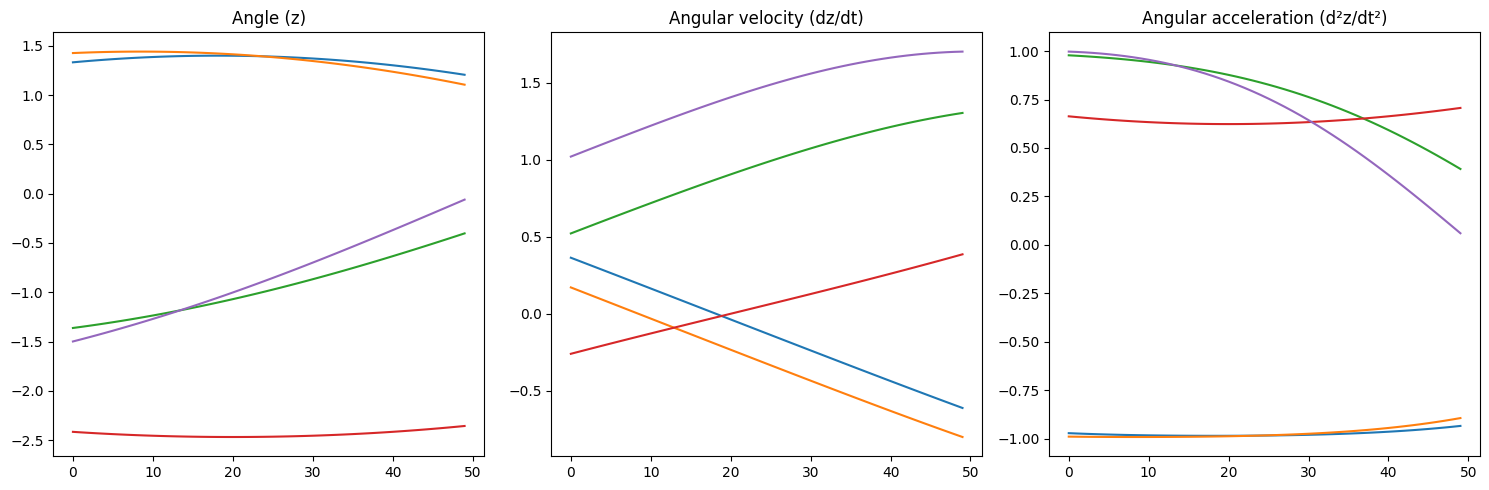

In [2]:
import matplotlib.pyplot as plt

# Ground truth coefficients (all zeros except -1 for sin term)
coefficients = np.zeros(len(terms))
coefficients[3] = -1.0  # coefficient for sin(z)

# Create training data
z_data, dz_data, ddz_data = create_pendulum_data(
    z0_min=-np.pi, z0_max=np.pi,
    dz0_min=-2.1, dz0_max=2.1,
    coefficients=coefficients,
    terms=terms,
    T=50, dt=0.02,
    N=100
)

# Plot 5 random trajectories
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 3, 1)
    plt.plot(z_data[i])
    plt.title('Angle (z)')
    
    plt.subplot(1, 3, 2)
    plt.plot(dz_data[i])
    plt.title('Angular velocity (dz/dt)')
    
    plt.subplot(1, 3, 3)
    plt.plot(ddz_data[i])
    plt.title('Angular acceleration (d²z/dt²)')

plt.tight_layout()
plt.show()

#### 1.2 Implementation & Training

In [3]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

class SINDyLasso:
    def __init__(self, terms, alpha=1e-5):
        self.terms = terms
        self.alpha = alpha
        self.lasso = Lasso(alpha=alpha, fit_intercept=False)
        self.scaler = StandardScaler(with_mean=False)
        
    def fit(self, z, dz, ddz):
        # Flatten the data if it's 2D
        z = z.flatten()
        dz = dz.flatten()
        ddz = ddz.flatten()
        
        # Build library of terms
        theta = np.column_stack([term(z, dz) for term in self.terms])
        
        # Scale the library terms
        theta_scaled = self.scaler.fit_transform(theta)
        
        # Fit LASSO regression
        self.lasso.fit(theta_scaled, ddz)
        
        # Store unscaled coefficients
        self.coefficients = self.lasso.coef_ / self.scaler.scale_
        
    def predict(self, z, dz):
        # Ensure inputs are flattened
        z = z.flatten()
        dz = dz.flatten()
        theta = np.column_stack([term(z, dz) for term in self.terms])
        return np.dot(theta, self.coefficients)

class SINDyTorch(nn.Module):
    def __init__(self, terms):
        super().__init__()
        self.terms = terms
        self.coefficients = nn.Parameter(torch.ones(len(terms)))
        self.mask = torch.ones_like(self.coefficients, dtype=torch.bool)
        
    def forward(self, z, dz):
        # Flatten inputs if they're 2D
        if len(z.shape) > 1:
            z = z.flatten()
            dz = dz.flatten()
            
        # Build library of terms
        theta = torch.stack([
            torch.tensor(term(z.cpu().detach().numpy(), 
                            dz.cpu().detach().numpy()),
                        dtype=torch.float32)
            for term in self.terms
        ], dim=1)
        
        # Apply mask and compute prediction
        masked_coefficients = self.coefficients * self.mask
        return torch.matmul(theta, masked_coefficients)

def train_sindy(model, z_train, dz_train, ddz_train, z_val, dz_val, ddz_val,
                num_epochs=1000, learning_rate=1e-3, l1_lambda=1e-5,
                thresholding=None, threshold=0.1, threshold_interval=500,
                device='cuda' if torch.cuda.is_available() else 'cpu'):
    
    # Flatten all inputs
    z_train = torch.tensor(z_train.flatten(), dtype=torch.float32).to(device)
    dz_train = torch.tensor(dz_train.flatten(), dtype=torch.float32).to(device)
    ddz_train = torch.tensor(ddz_train.flatten(), dtype=torch.float32).to(device)
    
    z_val = torch.tensor(z_val.flatten(), dtype=torch.float32).to(device)
    dz_val = torch.tensor(dz_val.flatten(), dtype=torch.float32).to(device)
    ddz_val = torch.tensor(ddz_val.flatten(), dtype=torch.float32).to(device)
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    coef_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        # Forward pass
        ddz_pred = model(z_train, dz_train)
        
        # Compute losses
        mse_loss = nn.MSELoss()(ddz_pred, ddz_train)
        l1_reg = l1_lambda * torch.norm(model.coefficients, p=1)
        loss = mse_loss + l1_reg
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Apply thresholding if enabled
        if thresholding == "sequential" and epoch % threshold_interval == 0:
            with torch.no_grad():
                mask = torch.abs(model.coefficients) >= threshold
                model.mask = mask
                model.coefficients[~mask] = 0
        
        # Validation
        model.eval()
        with torch.no_grad():
            ddz_val_pred = model(z_val, dz_val)
            val_loss = nn.MSELoss()(ddz_val_pred, ddz_val)
        
        # Log metrics
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        coef_history.append(model.coefficients.detach().cpu().numpy())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {loss.item():.4f}, '
                  f'Val Loss: {val_loss.item():.4f}')
    
    return train_losses, val_losses, np.array(coef_history)

def compare_sindy_implementations(z_data, dz_data, ddz_data, terms):
    # Split data into train and validation sets
    train_idx = int(0.8 * len(z_data))
    z_train, z_val = z_data[:train_idx], z_data[train_idx:]
    dz_train, dz_val = dz_data[:train_idx], dz_data[train_idx:]
    ddz_train, ddz_val = ddz_data[:train_idx], ddz_data[train_idx:]
    
    # Train LASSO version
    sindy_lasso = SINDyLasso(terms, alpha=1e-5)
    sindy_lasso.fit(z_train, dz_train, ddz_train)
    
    # Train PyTorch version
    sindy_torch = SINDyTorch(terms)
    train_losses, val_losses, coef_history = train_sindy(
        sindy_torch, z_train, dz_train, ddz_train, z_val, dz_val, ddz_val,
        num_epochs=1000, l1_lambda=1e-5, thresholding="sequential"
    )
    
    return (sindy_lasso.coefficients, 
            sindy_torch.coefficients.detach().cpu().numpy(),
            train_losses, val_losses, coef_history)

Epoch [100/1000], Train Loss: 36.1826, Val Loss: 41.3534
Epoch [200/1000], Train Loss: 29.3602, Val Loss: 33.5326
Epoch [300/1000], Train Loss: 23.5727, Val Loss: 26.8986
Epoch [400/1000], Train Loss: 18.7125, Val Loss: 21.3283
Epoch [500/1000], Train Loss: 14.6758, Val Loss: 16.7030
Epoch [600/1000], Train Loss: 11.3632, Val Loss: 12.9091
Epoch [700/1000], Train Loss: 8.6804, Val Loss: 9.8383
Epoch [800/1000], Train Loss: 6.5381, Val Loss: 7.3885
Epoch [900/1000], Train Loss: 4.8535, Val Loss: 5.4645
Epoch [1000/1000], Train Loss: 3.5501, Val Loss: 3.9784

LASSO Coefficients:
constant: -0.000583
z_term: -0.000503
dz_term: 0.000040
sin_z: -0.999165
z_squared: 0.000978
z_dz: -0.000374
z_sin_z: -0.005695
dz_squared: -0.000021
dz_sin_z: 0.000570
sin_z_squared: 0.007203

PyTorch Coefficients:
constant: 0.261827
z_term: 0.190310
dz_term: 0.276354
sin_z: 0.166080
z_squared: 0.259616
z_dz: 0.251268
z_sin_z: 0.260618
dz_squared: 0.264810
dz_sin_z: 0.253026
sin_z_squared: 0.261165


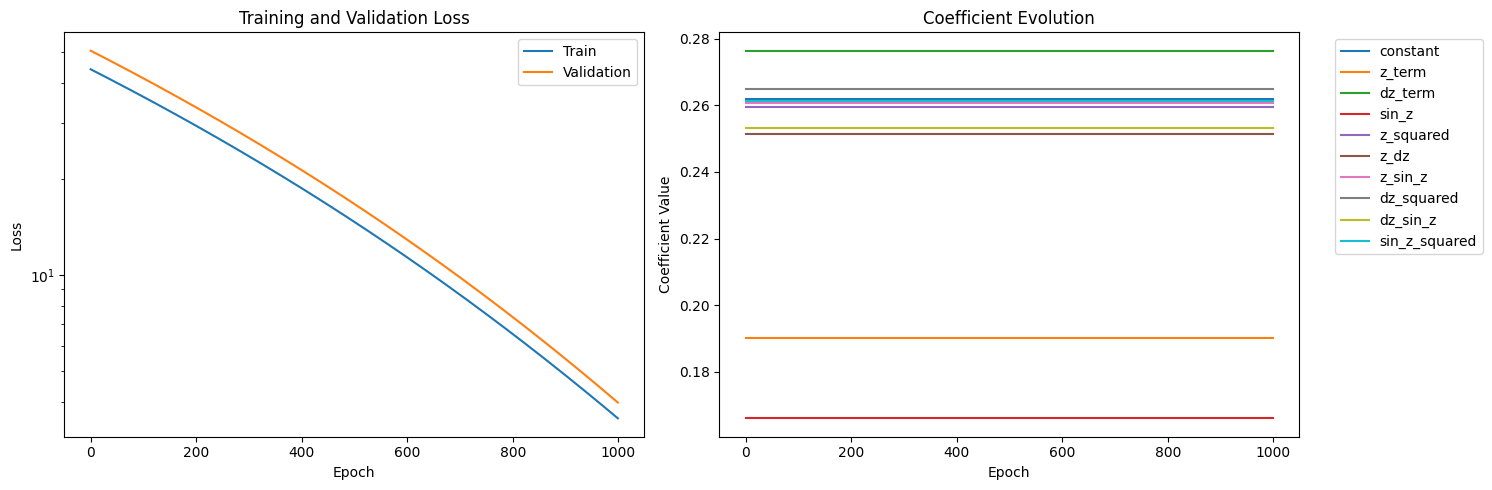

In [4]:
# Compare the implementations
lasso_coef, torch_coef, train_losses, val_losses, coef_history = \
    compare_sindy_implementations(z_data, dz_data, ddz_data, terms)

print("\nLASSO Coefficients:")
for term, coef in zip(terms, lasso_coef):
    print(f"{term.__name__}: {coef:.6f}")

print("\nPyTorch Coefficients:")
for term, coef in zip(terms, torch_coef):
    print(f"{term.__name__}: {coef:.6f}")

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(coef_history)
plt.xlabel('Epoch')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Evolution')
plt.legend([term.__name__ for term in terms], bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#### 1.3 Thresholding

In [5]:
import numpy as np
import torch
import torch.nn as nn

class SINDyTorch(nn.Module):
    def __init__(self, terms):
        super().__init__()
        self.terms = terms
        self.coefficients = nn.Parameter(torch.ones(len(terms)))
        self.mask = torch.ones_like(self.coefficients, dtype=torch.bool)
        
    def forward(self, z, dz):
        if len(z.shape) > 1:
            z = z.flatten()
            dz = dz.flatten()
            
        theta = torch.stack([
            torch.tensor(term(z.cpu().detach().numpy(), 
                            dz.cpu().detach().numpy()),
                        dtype=torch.float32)
            for term in self.terms
        ], dim=1)
        
        masked_coefficients = self.coefficients * self.mask
        return torch.matmul(theta, masked_coefficients)

def train_sindy(model, z_train, dz_train, ddz_train, z_val, dz_val, ddz_val,
                num_epochs=1000, learning_rate=1e-3, l1_lambda=1e-5,
                thresholding="none", threshold_a=0.1, threshold_b=0.002,
                threshold_interval=500, patience=1000,
                device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Train SINDy with either Sequential or Patient Trend-Aware Thresholding.
    
    Args:
        ... (previous parameters) ...
        thresholding: Type of thresholding ("none", "sequential", or "patient")
        threshold_a: Coefficient magnitude threshold
        threshold_b: Trend threshold for PTAT
        threshold_interval: Interval for sequential thresholding
        patience: Patience parameter for PTAT
    """
    # Initialize tensors
    z_train = torch.tensor(z_train.flatten(), dtype=torch.float32).to(device)
    dz_train = torch.tensor(dz_train.flatten(), dtype=torch.float32).to(device)
    ddz_train = torch.tensor(ddz_train.flatten(), dtype=torch.float32).to(device)
    
    z_val = torch.tensor(z_val.flatten(), dtype=torch.float32).to(device)
    dz_val = torch.tensor(dz_val.flatten(), dtype=torch.float32).to(device)
    ddz_val = torch.tensor(ddz_val.flatten(), dtype=torch.float32).to(device)
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize PTAT variables if needed
    if thresholding == "patient":
        prev_coefficients = torch.zeros_like(model.coefficients)
        last_threshold_a = torch.zeros_like(model.coefficients)
        last_threshold_b = torch.zeros_like(model.coefficients)
    
    train_losses = []
    val_losses = []
    coef_history = []
    mask_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        # Forward pass and loss computation
        ddz_pred = model(z_train, dz_train)
        mse_loss = nn.MSELoss()(ddz_pred, ddz_train)
        l1_reg = l1_lambda * torch.norm(model.coefficients, p=1)
        loss = mse_loss + l1_reg
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Apply thresholding
        with torch.no_grad():
            if thresholding == "sequential" and epoch % threshold_interval == 0:
                # Sequential Thresholding
                mask = torch.abs(model.coefficients) >= threshold_a
                model.mask = mask
                model.coefficients[~mask] = 0
                
            elif thresholding == "patient":
                # Patient Trend-Aware Thresholding
                # Update last threshold crossing epochs
                exceeded_a = torch.abs(model.coefficients) > threshold_a
                exceeded_b = torch.abs(model.coefficients - prev_coefficients) > threshold_b
                
                last_threshold_a[exceeded_a] = epoch
                last_threshold_b[exceeded_b] = epoch
                
                # Compute active terms based on patience
                active_a = (epoch - last_threshold_a) < patience
                active_b = (epoch - last_threshold_b) < patience
                new_mask = active_a | active_b
                
                # Update mask and coefficients
                model.mask = model.mask & new_mask
                model.coefficients[~model.mask] = 0
                
                # Store current coefficients for next iteration
                prev_coefficients = model.coefficients.clone()
        
        # Validation
        model.eval()
        with torch.no_grad():
            ddz_val_pred = model(z_val, dz_val)
            val_loss = nn.MSELoss()(ddz_val_pred, ddz_val)
        
        # Logging
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        coef_history.append(model.coefficients.detach().cpu().numpy())
        mask_history.append(model.mask.cpu().numpy())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {loss.item():.4f}, '
                  f'Val Loss: {val_loss.item():.4f}, '
                  f'Active Terms: {model.mask.sum().item()}')
    
    return train_losses, val_losses, np.array(coef_history), np.array(mask_history)

#### 1.4 Evaluation & Visualization

Training with Sequential Thresholding...
Epoch [100/5000], Train Loss: 34.3245, Val Loss: 43.6793, Active Terms: 10
Epoch [200/5000], Train Loss: 27.9082, Val Loss: 35.5975, Active Terms: 10
Epoch [300/5000], Train Loss: 22.4565, Val Loss: 28.7142, Active Terms: 10
Epoch [400/5000], Train Loss: 17.8701, Val Loss: 22.9080, Active Terms: 10
Epoch [500/5000], Train Loss: 14.0531, Val Loss: 18.0621, Active Terms: 10
Epoch [600/5000], Train Loss: 10.9138, Val Loss: 14.0644, Active Terms: 10
Epoch [700/5000], Train Loss: 8.3649, Val Loss: 10.8078, Active Terms: 10
Epoch [800/5000], Train Loss: 6.3239, Val Loss: 8.1911, Active Terms: 10
Epoch [900/5000], Train Loss: 4.7138, Val Loss: 6.1193, Active Terms: 10
Epoch [1000/5000], Train Loss: 3.4637, Val Loss: 4.5047, Active Terms: 10
Epoch [1100/5000], Train Loss: 2.5091, Val Loss: 3.2672, Active Terms: 10
Epoch [1200/5000], Train Loss: 1.7929, Val Loss: 2.3354, Active Terms: 10
Epoch [1300/5000], Train Loss: 1.2649, Val Loss: 1.6463, Active Ter

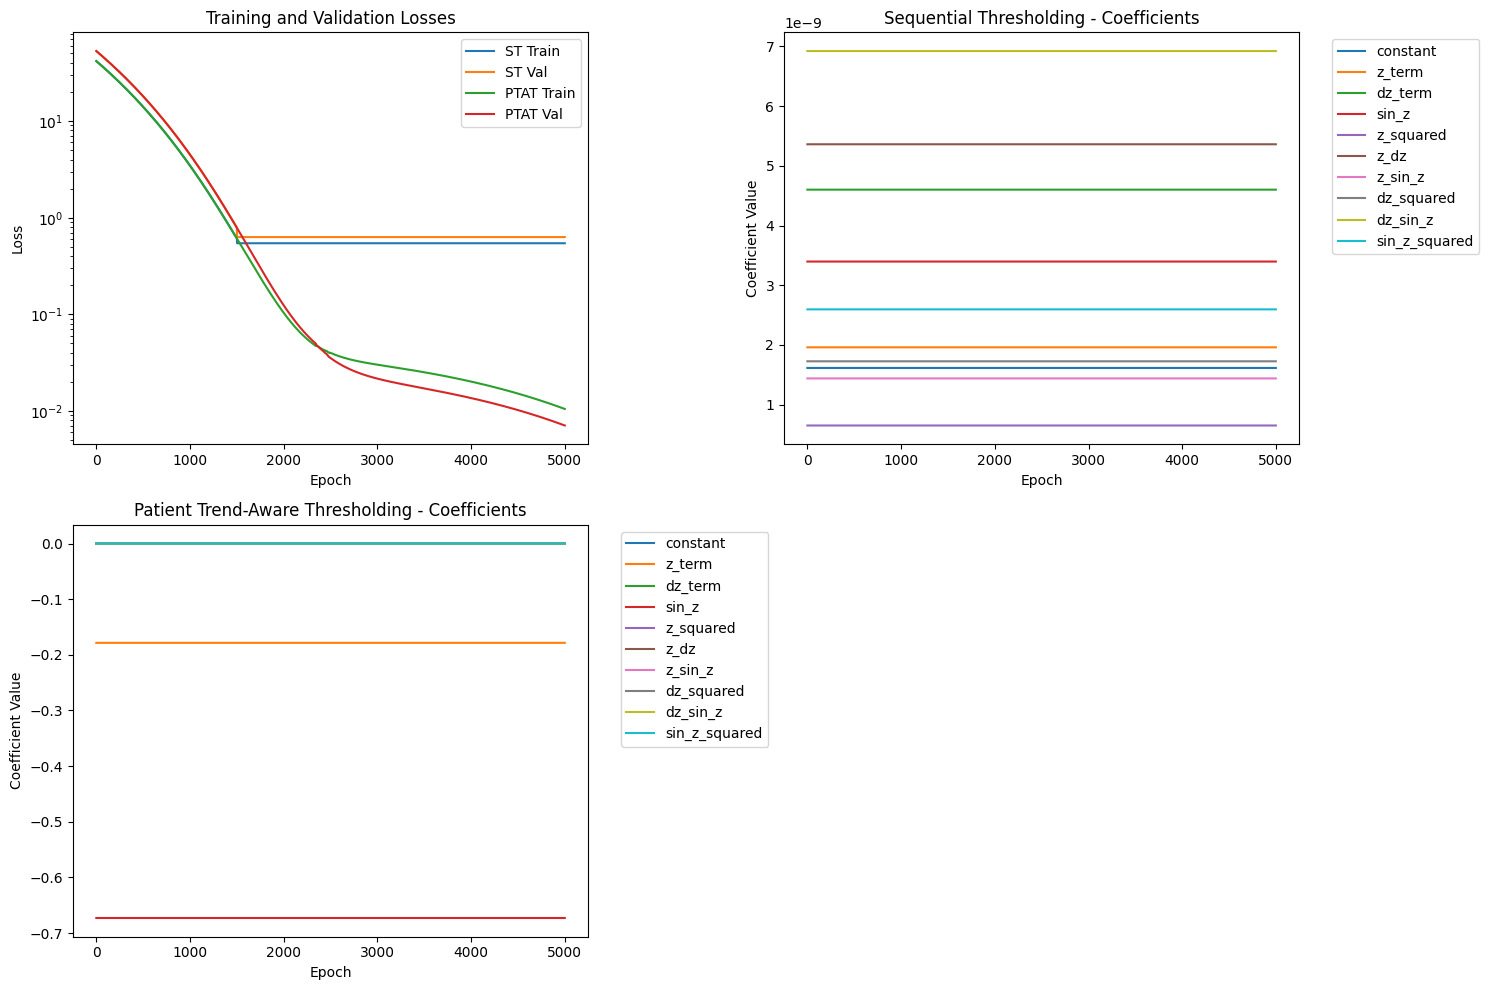

In [6]:
# Ground truth coefficients (all zeros except -1 for sin term)
coefficients = np.zeros(len(terms))
coefficients[3] = -1.0  # coefficient for sin(z)

# Create training data
z_data, dz_data, ddz_data = create_pendulum_data(
    z0_min=-np.pi, z0_max=np.pi,
    dz0_min=-2.1, dz0_max=2.1,
    coefficients=coefficients,
    terms=terms,
    T=50, dt=0.02,
    N=100
)

# Split data into train and validation sets
train_idx = int(0.8 * len(z_data))
z_train, z_val = z_data[:train_idx], z_data[train_idx:]
dz_train, dz_val = dz_data[:train_idx], dz_data[train_idx:]
ddz_train, ddz_val = ddz_data[:train_idx], ddz_data[train_idx:]

# Create two identical models for comparison
model_st = SINDyTorch(terms)
model_ptat = SINDyTorch(terms)

# Train with Sequential Thresholding
print("Training with Sequential Thresholding...")
st_results = train_sindy(
    model_st, z_train, dz_train, ddz_train, z_val, dz_val, ddz_val,
    num_epochs=5000,
    thresholding="sequential",
    threshold_a=0.1,
    threshold_interval=500
)

# Train with Patient Trend-Aware Thresholding
print("\nTraining with Patient Trend-Aware Thresholding...")
ptat_results = train_sindy(
    model_ptat, z_train, dz_train, ddz_train, z_val, dz_val, ddz_val,
    num_epochs=5000,
    thresholding="patient",
    threshold_a=0.1,
    threshold_b=0.002,
    patience=1000
)

# Plot comparison
plt.figure(figsize=(15, 10))

# Plot losses
plt.subplot(2, 2, 1)
plt.plot(st_results[0], label='ST Train')
plt.plot(st_results[1], label='ST Val')
plt.plot(ptat_results[0], label='PTAT Train')
plt.plot(ptat_results[1], label='PTAT Val')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plot coefficient evolution for ST
plt.subplot(2, 2, 2)
plt.plot(st_results[2])
plt.xlabel('Epoch')
plt.ylabel('Coefficient Value')
plt.title('Sequential Thresholding - Coefficients')
plt.legend([term.__name__ for term in terms], bbox_to_anchor=(1.05, 1))

# Plot coefficient evolution for PTAT
plt.subplot(2, 2, 3)
plt.plot(ptat_results[2])
plt.xlabel('Epoch')
plt.ylabel('Coefficient Value')
plt.title('Patient Trend-Aware Thresholding - Coefficients')
plt.legend([term.__name__ for term in terms], bbox_to_anchor=(1.05, 1))

print("\nFinal Coefficients:")
print("Term\t\tST\t\tPTAT")
print("-" * 40)
for i, term in enumerate(terms):
    print(f"{term.__name__:10s}\t{model_st.coefficients[i].item():10.6f}\t{model_ptat.coefficients[i].item():10.6f}")

plt.tight_layout()
plt.show()

#### 1.5 Small Angle Approximation

Training with Sequential Thresholding (small initial conditions)...
Epoch [100/5000], Train Loss: 0.8956, Val Loss: 0.8340, Active Terms: 10
Epoch [200/5000], Train Loss: 0.7226, Val Loss: 0.6716, Active Terms: 10
Epoch [300/5000], Train Loss: 0.5762, Val Loss: 0.5344, Active Terms: 10
Epoch [400/5000], Train Loss: 0.4538, Val Loss: 0.4198, Active Terms: 10
Epoch [500/5000], Train Loss: 0.3526, Val Loss: 0.3252, Active Terms: 10
Epoch [600/5000], Train Loss: 0.2699, Val Loss: 0.2481, Active Terms: 10
Epoch [700/5000], Train Loss: 0.2034, Val Loss: 0.1863, Active Terms: 10
Epoch [800/5000], Train Loss: 0.1508, Val Loss: 0.1375, Active Terms: 10
Epoch [900/5000], Train Loss: 0.1098, Val Loss: 0.0996, Active Terms: 10
Epoch [1000/5000], Train Loss: 0.0786, Val Loss: 0.0708, Active Terms: 10
Epoch [1100/5000], Train Loss: 0.0551, Val Loss: 0.0494, Active Terms: 10
Epoch [1200/5000], Train Loss: 0.0380, Val Loss: 0.0337, Active Terms: 10
Epoch [1300/5000], Train Loss: 0.0257, Val Loss: 0.02

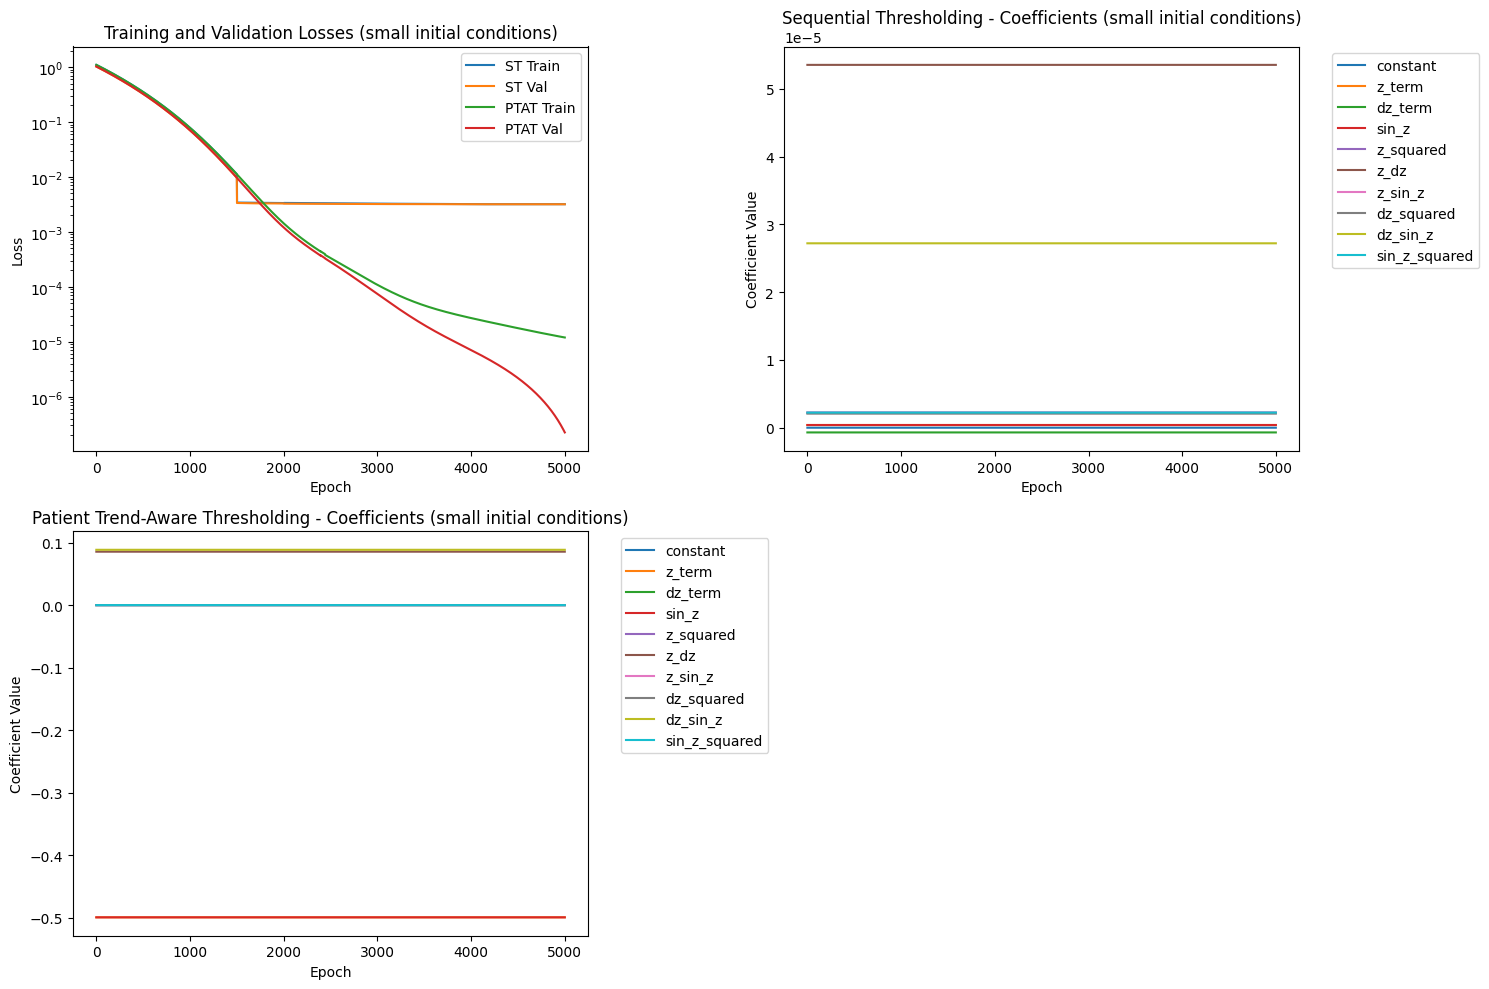

In [23]:
# Create training data with small initial conditions
z_data_small, dz_data_small, ddz_data_small = create_pendulum_data(
    z0_min=-0.1, z0_max=0.1,
    dz0_min=-0.1, dz0_max=0.1,
    coefficients=coefficients,
    terms=terms,
    T=50, dt=0.02,
    N=100,
    rejection=False
)

# Split data into train and validation sets
train_idx = int(0.8 * len(z_data_small))
z_train_small, z_val_small = z_data_small[:train_idx], z_data_small[train_idx:]
dz_train_small, dz_val_small = dz_data_small[:train_idx], dz_data_small[train_idx:]
ddz_train_small, ddz_val_small = ddz_data_small[:train_idx], ddz_data_small[train_idx:]

# Create two identical models for comparison
model_st_small = SINDyTorch(terms)
model_ptat_small = SINDyTorch(terms)

# Train with Sequential Thresholding
print("Training with Sequential Thresholding (small initial conditions)...")
st_results_small = train_sindy(
    model_st_small, z_train_small, dz_train_small, ddz_train_small, z_val_small, dz_val_small, ddz_val_small,
    num_epochs=5000,
    thresholding="sequential",
    threshold_a=0.1,
    threshold_interval=500
)

# Train with Patient Trend-Aware Thresholding
print("\nTraining with Patient Trend-Aware Thresholding (small initial conditions)...")
ptat_results_small = train_sindy(
    model_ptat_small, z_train_small, dz_train_small, ddz_train_small, z_val_small, dz_val_small, ddz_val_small,
    num_epochs=5000,
    thresholding="patient",
    threshold_a=0.1,
    threshold_b=0.002,
    patience=1000
)

# Plot comparison
plt.figure(figsize=(15, 10))

# Plot losses
plt.subplot(2, 2, 1)
plt.plot(st_results_small[0], label='ST Train')
plt.plot(st_results_small[1], label='ST Val')
plt.plot(ptat_results_small[0], label='PTAT Train')
plt.plot(ptat_results_small[1], label='PTAT Val')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses (small initial conditions)')
plt.legend()

# Plot coefficient evolution for ST
plt.subplot(2, 2, 2)
plt.plot(st_results_small[2])
plt.xlabel('Epoch')
plt.ylabel('Coefficient Value')
plt.title('Sequential Thresholding - Coefficients (small initial conditions)')
plt.legend([term.__name__ for term in terms], bbox_to_anchor=(1.05, 1))

# Plot coefficient evolution for PTAT
plt.subplot(2, 2, 3)
plt.plot(ptat_results_small[2])
plt.xlabel('Epoch')
plt.ylabel('Coefficient Value')
plt.title('Patient Trend-Aware Thresholding - Coefficients (small initial conditions)')
plt.legend([term.__name__ for term in terms], bbox_to_anchor=(1.05, 1))

print("\nFinal Coefficients (small initial conditions):")
print("Term\t\tST\t\tPTAT")
print("-" * 40)
for i, term in enumerate(terms):
    print(f"{term.__name__:10s}\t{model_st_small.coefficients[i].item():10.6f}\t{model_ptat_small.coefficients[i].item():10.6f}")

plt.tight_layout()
plt.show()

#### 2.1 Cartesian Embedding

In [7]:
import torch

def embed_cartesian(z, dz, ddz):
    """
    Convert pendulum angle coordinates to cartesian coordinates.
    
    Parameters:
    z (torch.Tensor): Deflection angle
    dz (torch.Tensor): First derivative of deflection angle
    ddz (torch.Tensor): Second derivative of deflection angle
    
    Returns:
    tuple: (x, dx, ddx) where:
        x: Position in cartesian coordinates [sin(z), -cos(z)]
        dx: First derivative in cartesian coordinates
        ddx: Second derivative in cartesian coordinates
    """
    # Ensure the input tensors are 2D
    z = z.view(-1, 1)
    dz = dz.view(-1, 1)
    ddz = ddz.view(-1, 1)
    
    # Equation (5): Position
    x = torch.cat([
        torch.sin(z),
        -torch.cos(z)
    ], dim=1)
    
    # Equation (6): First derivative
    dx = torch.cat([
        torch.cos(z) * dz,
        torch.sin(z) * dz
    ], dim=1)
    
    # Equation (7): Second derivative
    ddx = torch.cat([
        -torch.sin(z) * dz**2 + torch.cos(z) * ddz,
        torch.cos(z) * dz**2 + torch.sin(z) * ddz
    ], dim=1)
    
    return x, dx, ddx

# Test the implementation
def test_cartesian_embedding():
    # Create test data
    z = torch.tensor([0.0, torch.pi/4, torch.pi/2])  # Some test angles
    dz = torch.ones_like(z)  # Unit angular velocity
    ddz = torch.zeros_like(z)  # Zero angular acceleration
    
    # Apply transformation
    x, dx, ddx = embed_cartesian(z, dz, ddz)
    
    print("Test results:")
    print(f"Input shapes - z: {z.shape}, dz: {dz.shape}, ddz: {ddz.shape}")
    print(f"Output shapes - x: {x.shape}, dx: {dx.shape}, ddx: {ddx.shape}")
    print("\nCartesian coordinates at each angle:")
    for i in range(len(z)):
        print(f"Angle {z[i].item():.2f}:")
        print(f"  Position (x, y): ({x[i, 0].item():.2f}, {x[i, 1].item():.2f})")
        print(f"  Velocity (dx, dy): ({dx[i, 0].item():.2f}, {dx[i, 1].item():.2f})")
        print(f"  Acceleration (ddx, ddy): ({ddx[i, 0].item():.2f}, {ddx[i, 1].item():.2f})")

test_cartesian_embedding()

Test results:
Input shapes - z: torch.Size([3]), dz: torch.Size([3]), ddz: torch.Size([3])
Output shapes - x: torch.Size([3, 2]), dx: torch.Size([3, 2]), ddx: torch.Size([3, 2])

Cartesian coordinates at each angle:
Angle 0.00:
  Position (x, y): (0.00, -1.00)
  Velocity (dx, dy): (1.00, 0.00)
  Acceleration (ddx, ddy): (0.00, 1.00)
Angle 0.79:
  Position (x, y): (0.71, -0.71)
  Velocity (dx, dy): (0.71, 0.71)
  Acceleration (ddx, ddy): (-0.71, 0.71)
Angle 1.57:
  Position (x, y): (1.00, 0.00)
  Velocity (dx, dy): (-0.00, 1.00)
  Acceleration (ddx, ddy): (-1.00, -0.00)


#### 2.2 Hyperparamter Optimization

Testing configurations: 100%|██████████| 8/8 [01:31<00:00, 11.41s/it]


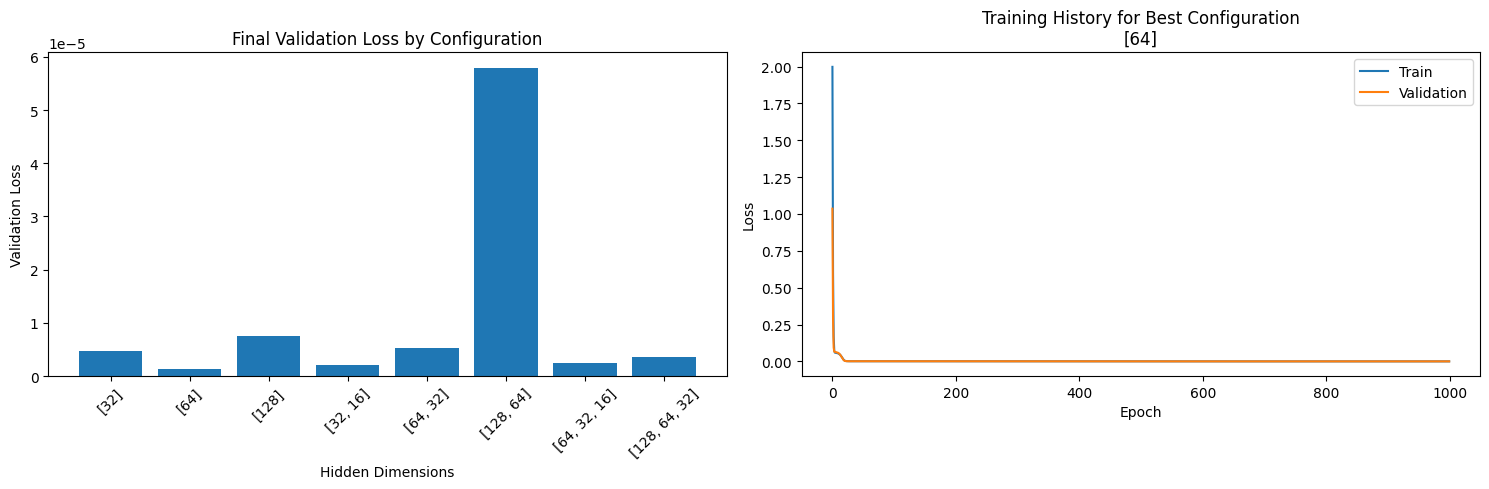


Best configuration:
Hidden dimensions: [64]
Final validation loss: 0.000001


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np

class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[64, 32], latent_dim=1):
        super().__init__()
        
        # Encoder
        encoder_layers = []
        dims = [input_dim] + hidden_dims + [latent_dim]
        for i in range(len(dims)-1):
            encoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:  # No sigmoid after last layer
                encoder_layers.append(nn.Sigmoid())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        dims = [latent_dim] + hidden_dims[::-1] + [input_dim]
        for i in range(len(dims)-1):
            decoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:  # No sigmoid after last layer
                decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Initialize weights using Xavier uniform
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def train_autoencoder(model, train_loader, val_loader, epochs=1000, device='cuda'):
    """Train the autoencoder and return training history"""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)  # Only need x, not dx or ddx yet
            
            optimizer.zero_grad()
            x_recon, _ = model(x)
            loss = criterion(x_recon, x)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                x_recon, _ = model(x)
                val_loss += criterion(x_recon, x).item()
        val_loss /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
    return history

def hyperparameter_optimization(x_train, x_val, batch_size=32):
    """Try different hyperparameters and return the best configuration"""
    # Create datasets
    train_dataset = TensorDataset(x_train)
    val_dataset = TensorDataset(x_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Define hyperparameter configurations to try
    configs = [
        {'hidden_dims': [32]},
        {'hidden_dims': [64]},
        {'hidden_dims': [128]},
        {'hidden_dims': [32, 16]},
        {'hidden_dims': [64, 32]},
        {'hidden_dims': [128, 64]},
        {'hidden_dims': [64, 32, 16]},
        {'hidden_dims': [128, 64, 32]}
    ]
    
    results = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for config in tqdm(configs, desc="Testing configurations"):
        model = SimpleAutoencoder(
            input_dim=2,
            hidden_dims=config['hidden_dims'],
            latent_dim=1
        )
        
        history = train_autoencoder(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=1000,
            device=device
        )
        
        results.append({
            'config': config,
            'final_train_loss': history['train_loss'][-1],
            'final_val_loss': history['val_loss'][-1],
            'model': model,
            'history': history
        })
    
    # Find best configuration
    best_result = min(results, key=lambda x: x['final_val_loss'])
    
    return results, best_result

def plot_results(results):
    """Plot the training results for all configurations"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 5))
    
    # Plot final validation loss for each configuration
    plt.subplot(121)
    configs = [f"{r['config']['hidden_dims']}" for r in results]
    val_losses = [r['final_val_loss'] for r in results]
    plt.bar(range(len(configs)), val_losses)
    plt.xticks(range(len(configs)), configs, rotation=45)
    plt.title('Final Validation Loss by Configuration')
    plt.xlabel('Hidden Dimensions')
    plt.ylabel('Validation Loss')
    
    # Plot training history for best configuration
    best_result = min(results, key=lambda x: x['final_val_loss'])
    plt.subplot(122)
    plt.plot(best_result['history']['train_loss'], label='Train')
    plt.plot(best_result['history']['val_loss'], label='Validation')
    plt.title(f'Training History for Best Configuration\n{best_result["config"]["hidden_dims"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Generate some sample data
n_samples = 1000
t = torch.linspace(0, 10, n_samples)
z = 0.5 * torch.cos(2 * np.pi * t)

# Use the cartesian embedding from 2.1
x, _, _ = embed_cartesian(z[:, None], 
                        torch.zeros_like(z[:, None]), 
                        torch.zeros_like(z[:, None]))

# Split data
train_idx = torch.arange(800)
val_idx = torch.arange(800, 1000)

# Run hyperparameter optimization
results, best_result = hyperparameter_optimization(
    x_train=x[train_idx],
    x_val=x[val_idx]
)

# Plot results
plot_results(results)

print("\nBest configuration:")
print(f"Hidden dimensions: {best_result['config']['hidden_dims']}")
print(f"Final validation loss: {best_result['final_val_loss']:.6f}")

#### 2.3 Time Derivative Propagation


Linear Layer Results:
First derivative error: 13.398658
Second derivative error: 489.192444


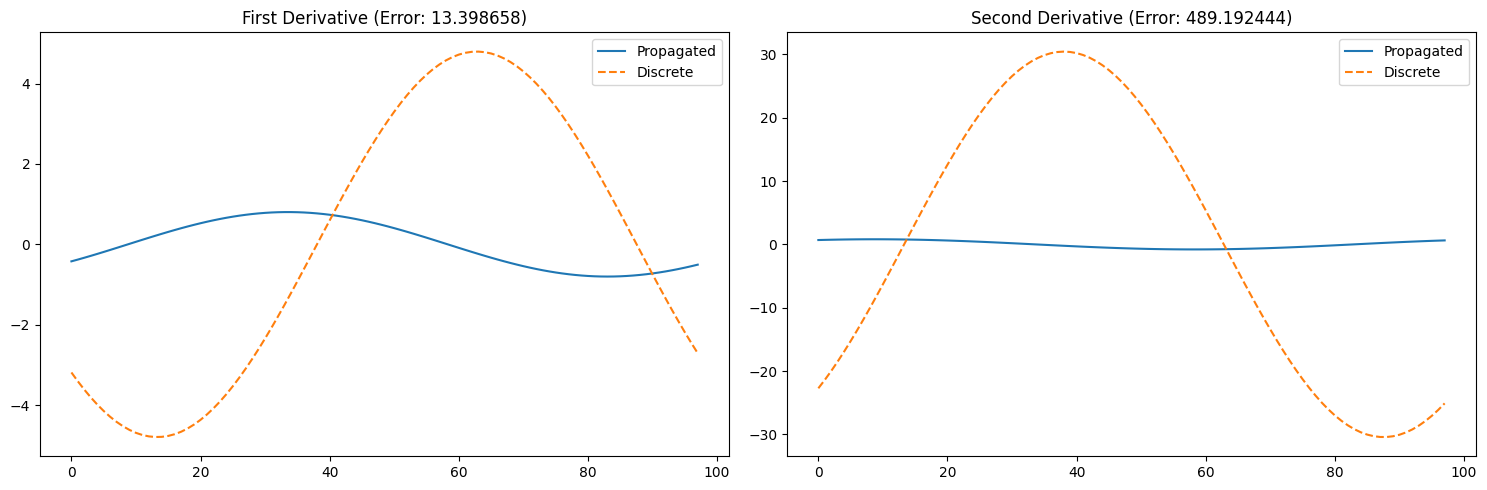


Sigmoid Layer Results:
First derivative error: 0.784562
Second derivative error: 44.563248


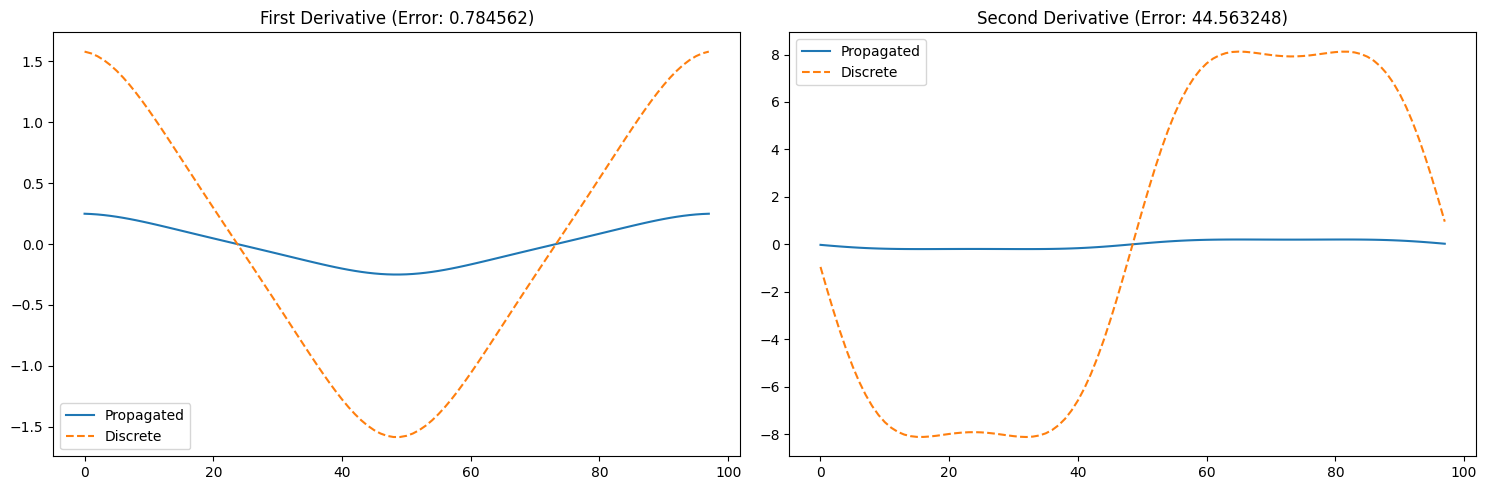

In [9]:
import torch
import torch.nn as nn
import numpy as np

class LinearDerivatives(nn.Linear):
    """Linear layer with derivative propagation"""
    def forward(self, z, dz=None, ddz=None):
        """
        Forward pass with optional derivative propagation
        
        Parameters:
        z: Input
        dz: First derivative (optional)
        ddz: Second derivative (optional)
        
        Returns:
        If dz and ddz are None:
            z_next: Output
        Else:
            (z_next, dz_next, ddz_next): Output and its derivatives
        """
        # Regular forward pass
        z_next = super().forward(z)
        
        # If no derivatives provided, return regular output
        if dz is None:
            return z_next
            
        # Propagate derivatives through linear layer
        # From Algorithm 3: z̃ₗ = zₗ₋₁Wₗ + bₗ
        dz_next = torch.matmul(dz, self.weight)  # First derivative
        ddz_next = torch.matmul(ddz, self.weight)  # Second derivative
        
        return z_next, dz_next, ddz_next

class SigmoidDerivatives(nn.Module):
    """Sigmoid activation with derivative propagation"""
    def forward(self, z, dz=None, ddz=None):
        """
        Forward pass with optional derivative propagation
        
        Parameters:
        z: Pre-activation
        dz: First derivative of pre-activation (optional)
        ddz: Second derivative of pre-activation (optional)
        
        Returns:
        If dz and ddz are None:
            z_next: Activated output
        Else:
            (z_next, dz_next, ddz_next): Activated output and its derivatives
        """
        # Regular sigmoid
        z_next = torch.sigmoid(z)
        
        # If no derivatives provided, return regular output
        if dz is None:
            return z_next
            
        # First derivative of sigmoid: σ'(z) = σ(z)(1 - σ(z))
        sig_prime = z_next * (1 - z_next)
        
        # Second derivative of sigmoid: σ''(z) = σ'(z)(1 - 2σ(z))
        sig_dprime = sig_prime * (1 - 2 * z_next)
        
        # Propagate derivatives through sigmoid
        # From Algorithm 3:
        # żₗ = g'(z̃ₗ)·ż̃ₗ
        dz_next = sig_prime * dz
        
        # z̈ₗ = (g''(z̃ₗ)·ż̃ₗ)·ż̃ₗ + g'(z̃ₗ)·z̈̃ₗ
        ddz_next = (sig_dprime * dz) * dz + sig_prime * ddz
        
        return z_next, dz_next, ddz_next

def verify_derivatives(layer, dt=0.01):
    """
    Verify derivative propagation by comparing with discrete derivatives
    
    Parameters:
    layer: Layer to test (LinearDerivatives or SigmoidDerivatives)
    dt: Time step for discrete derivatives
    """
    # Generate test sequence
    t = torch.linspace(0, 2*np.pi, 100)
    
    # Create input sequence and its analytical derivatives
    if isinstance(layer, LinearDerivatives):
        # Use simple linear function for testing linear layer
        z = torch.stack([torch.sin(t), torch.cos(t)], dim=1)
        dz = torch.stack([torch.cos(t), -torch.sin(t)], dim=1)
        ddz = torch.stack([-torch.sin(t), -torch.cos(t)], dim=1)
    else:
        # Use scalar input for testing sigmoid
        z = torch.sin(t).reshape(-1, 1)
        dz = torch.cos(t).reshape(-1, 1)
        ddz = -torch.sin(t).reshape(-1, 1)
    
    # Forward pass with derivative propagation
    z_next, dz_prop, ddz_prop = layer(z, dz, ddz)
    
    # Compute discrete derivatives
    z_prev = z_next[:-2]
    z_curr = z_next[1:-1]
    z_next = z_next[2:]
    
    # Central difference for first derivative
    dz_disc = (z_next - z_prev) / (2 * dt)
    
    # Central difference for second derivative
    ddz_disc = (z_next - 2*z_curr + z_prev) / (dt**2)
    
    # Compare propagated vs discrete derivatives
    dz_error = torch.mean((dz_prop[1:-1] - dz_disc)**2)
    ddz_error = torch.mean((ddz_prop[1:-1] - ddz_disc)**2)
    
    return {
        'dz_error': dz_error.item(),
        'ddz_error': ddz_error.item(),
        'dz_prop': dz_prop[1:-1],
        'dz_disc': dz_disc,
        'ddz_prop': ddz_prop[1:-1],
        'ddz_disc': ddz_disc
    }

def plot_verification(results):
    """Plot the verification results"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 5))
    
    # Plot first derivatives
    plt.subplot(121)
    plt.plot(results['dz_prop'][:, 0].detach(), label='Propagated')
    plt.plot(results['dz_disc'][:, 0].detach(), '--', label='Discrete')
    plt.title(f'First Derivative (Error: {results["dz_error"]:.6f})')
    plt.legend()
    
    # Plot second derivatives
    plt.subplot(122)
    plt.plot(results['ddz_prop'][:, 0].detach(), label='Propagated')
    plt.plot(results['ddz_disc'][:, 0].detach(), '--', label='Discrete')
    plt.title(f'Second Derivative (Error: {results["ddz_error"]:.6f})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Test Linear layer
linear = LinearDerivatives(2, 2)
linear_results = verify_derivatives(linear)
print("\nLinear Layer Results:")
print(f"First derivative error: {linear_results['dz_error']:.6f}")
print(f"Second derivative error: {linear_results['ddz_error']:.6f}")
plot_verification(linear_results)

# Test Sigmoid layer
sigmoid = SigmoidDerivatives()
sigmoid_results = verify_derivatives(sigmoid)
print("\nSigmoid Layer Results:")
print(f"First derivative error: {sigmoid_results['dz_error']:.6f}")
print(f"Second derivative error: {sigmoid_results['ddz_error']:.6f}")
plot_verification(sigmoid_results)
          


#### 2.4 Implementation

100%|██████████| 1000/1000 [00:03<00:00, 302.81it/s]


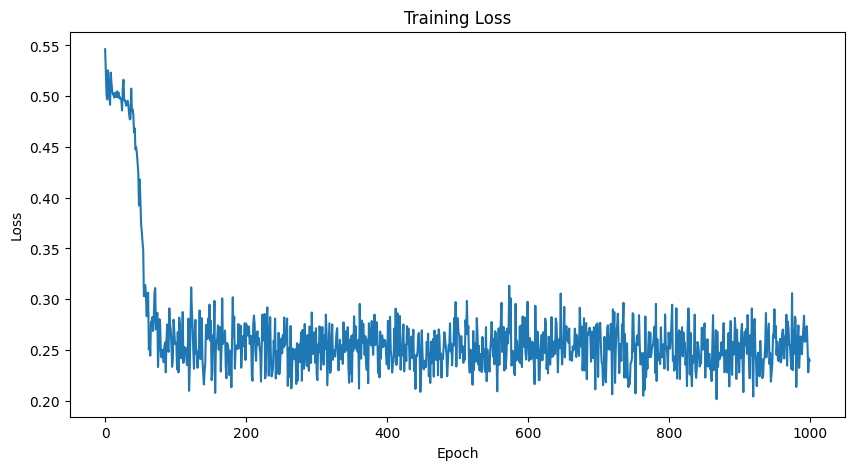

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SINDy(nn.Module):
    def __init__(self, n_terms):
        super().__init__()
        self.Xi = nn.Parameter(torch.randn(n_terms))
        self.register_buffer('mask', torch.ones_like(self.Xi))
        
    def forward(self, z, dz):
        library = self._build_library(z, dz)
        return (library * self.Xi * self.mask).sum(dim=-1)
    
    def _build_library(self, z, dz):
        # Example library terms: [1, z, z^2, z^3, dz, z*dz]
        return torch.stack([
            torch.ones_like(z),
            z,
            z**2,
            z**3,
            dz,
            z*dz
        ], dim=-1)
    
    def threshold(self, a):
        with torch.no_grad():
            self.mask[torch.abs(self.Xi) < a] = 0

class SINDyAutoencoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[64, 32], latent_dim=1):
        super().__init__()
        
        # Encoder
        encoder_layers = []
        dims = [input_dim] + hidden_dims + [latent_dim]
        for i in range(len(dims)-1):
            encoder_layers.extend([
                LinearDerivatives(dims[i], dims[i+1], bias=False),
                SigmoidDerivatives() if i < len(dims)-2 else nn.Identity()
            ])
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        dims = [latent_dim] + hidden_dims[::-1] + [input_dim]
        for i in range(len(dims)-1):
            decoder_layers.extend([
                LinearDerivatives(dims[i], dims[i+1], bias=False),
                SigmoidDerivatives() if i < len(dims)-2 else nn.Identity()
            ])
        self.decoder = nn.Sequential(*decoder_layers)
        
        # SINDy
        self.sindy = SINDy(n_terms=6)
        
        # Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    
    def forward(self, x, dx=None, ddx=None):
        # Encode
        z, dz, ddz = self._forward_with_derivatives(self.encoder, x, dx, ddx)
        
        # Predict z acceleration using SINDy
        z_ddz_pred = self.sindy(z, dz)
        
        # Decode
        x_rec, _, _ = self._forward_with_derivatives(self.decoder, z)
        x_dz, _, _ = self._forward_with_derivatives(self.decoder, dz)
        x_ddz_pred, _, _ = self._forward_with_derivatives(self.decoder, z_ddz_pred)
        
        return x_rec, ddz, z_ddz_pred, x_ddz_pred

    def _forward_with_derivatives(self, module, x, dx=None, ddx=None):
        if dx is None:
            return module(x), None, None
        else:
            z = module(x)
            dz = module(dx)
            ddz = module(ddx)
            return z, dz, ddz
        
def train_sindy_autoencoder(model, train_loader, optimizer, epochs=1000, 
                           lambda_z=5e-5, lambda_x=5e-4, lambda_sindy=1e-5):
    """Train the SINDyAutoencoder model"""
    losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_losses = []

        for x, dx, ddx in train_loader:
            x, dx, ddx = x.to(device), dx.to(device), ddx.to(device)

            # Forward pass
            x_rec, ddz, z_ddz_pred, x_ddz_pred = model(x, dx, ddx)

            # Loss computation
            mse_x = torch.mean((x - x_rec)**2)
            mse_ddz = torch.mean((ddz - z_ddz_pred)**2)
            mse_ddx = torch.mean((ddx - x_ddz_pred)**2)
            l1_sindy = torch.mean(torch.abs(model.sindy.Xi))

            # Total loss
            loss = mse_x + lambda_z * mse_ddz + lambda_x * mse_ddx + lambda_sindy * l1_sindy

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(np.mean(epoch_losses))

    return losses

# Generate synthetic data
z = torch.linspace(0, 2*np.pi, 100)
dz = torch.cos(z)
ddz = -torch.sin(z)

x, dx, ddx = embed_cartesian(z[:, None], dz[:, None], ddz[:, None])

# Create DataLoader
train_data = TensorDataset(x, dx, ddx)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Create SINDyAutoencoder model
model = SINDyAutoencoder(input_dim=2, hidden_dims=[64, 32], latent_dim=1)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
losses = train_sindy_autoencoder(model, train_loader, optimizer, epochs=1000)

# Plot the training losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


#### 2.5 Refinement

100%|██████████| 5000/5000 [00:16<00:00, 310.13it/s]


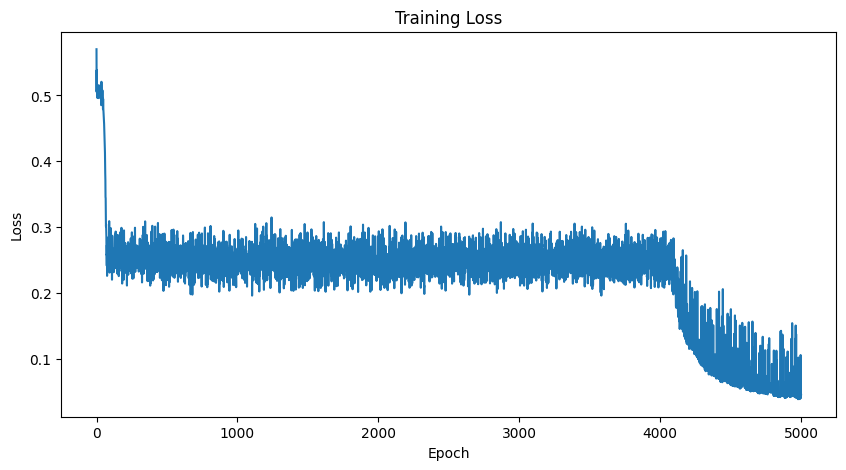

In [17]:
def train_sindy_autoencoder(model, train_loader, optimizer, epochs=1000,
                            lambda_z=5e-5, lambda_x=5e-4, lambda_sindy=1e-5,
                            refinement_epoch=4000):
    """Train the SINDyAutoencoder model"""
    losses = []
    
    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_losses = []
    
        for x, dx, ddx in train_loader:
                x, dx, ddx = x.to(device), dx.to(device), ddx.to(device)
    
                # Forward pass
                x_rec, ddz, z_ddz_pred, x_ddz_pred = model(x, dx, ddx)

                # Loss computation
                mse_x = torch.mean((x - x_rec)**2)
                mse_ddz = torch.mean((ddz - z_ddz_pred)**2)
                mse_ddx = torch.mean((ddx - x_ddz_pred)**2)
                l1_sindy = torch.mean(torch.abs(model.sindy.Xi))

                # Total loss
                loss = mse_x + lambda_z * mse_ddz + lambda_x * mse_ddx
                if epoch < refinement_epoch:
                    loss = loss + lambda_sindy * l1_sindy

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())

        losses.append(np.mean(epoch_losses))
          
    return losses

# Test the SINDyAutoencoder with refinement

# Create SINDyAutoencoder model
model = SINDyAutoencoder(input_dim=2, hidden_dims=[64, 32], latent_dim=1)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model with refinement
losses = train_sindy_autoencoder(model, train_loader, optimizer, epochs=5000, refinement_epoch=4000)

# Plot the training losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#### 2.6 Training


100%|██████████| 5000/5000 [01:39<00:00, 50.15it/s]


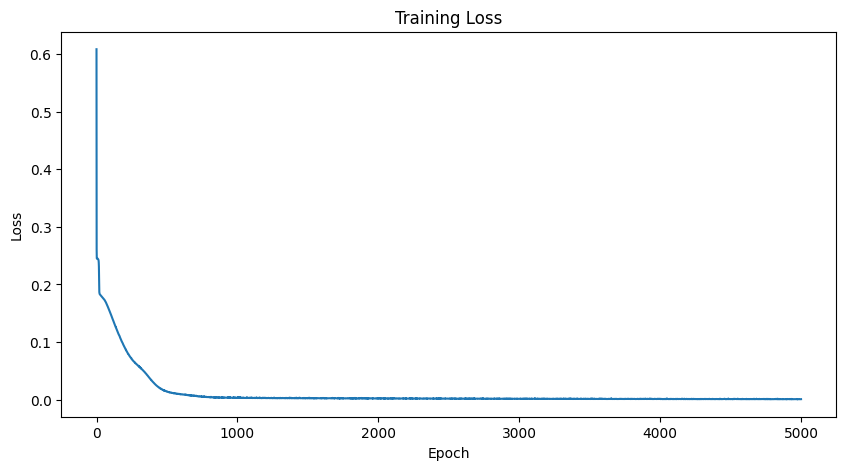

In [18]:
# Generate synthetic pendulum data (example)
def generate_pendulum_data(n_samples=1000, t_span=(0, 1), noise=0.01):
    t = np.linspace(t_span[0], t_span[1], n_samples)
    dt = t[1] - t[0]
    
    # Simple pendulum solution (approximation)
    z = 0.5 * np.cos(2 * np.pi * t)
    dz = -np.pi * np.sin(2 * np.pi * t)
    ddz = -(2 * np.pi)**2 * np.cos(2 * np.pi * t)
    
    # Add noise
    z += noise * np.random.randn(*z.shape)
    dz += noise * np.random.randn(*dz.shape)
    ddz += noise * np.random.randn(*ddz.shape)
    
    return torch.tensor(z, dtype=torch.float32), \
           torch.tensor(dz, dtype=torch.float32), \
           torch.tensor(ddz, dtype=torch.float32)

# Generate data
z, dz, ddz = generate_pendulum_data()

# Convert to cartesian coordinates
x, dx, ddx = embed_cartesian(z[:, None], dz[:, None], ddz[:, None])

# Create datasets
train_idx = torch.arange(800)
val_idx = torch.arange(800, 1000)

train_dataset = TensorDataset(x[train_idx], dx[train_idx], ddx[train_idx])
val_dataset = TensorDataset(x[val_idx], dx[val_idx], ddx[val_idx])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Create SINDyAutoencoder model
model = SINDyAutoencoder(input_dim=2, hidden_dims=[64, 32], latent_dim=1)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model with refinement
losses = train_sindy_autoencoder(model, train_loader, optimizer, epochs=5000, refinement_epoch=4000)

# Plot the training losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


#### 2.7 Evaluation & Visualization

FVU x: 0.0002
FVU ddz: 0.0013
FVU ddx: 0.0049

Learned SINDy coefficients:
[ 8.609522   4.6523685  0.620998  -7.0143776  5.78761   -3.4567428]


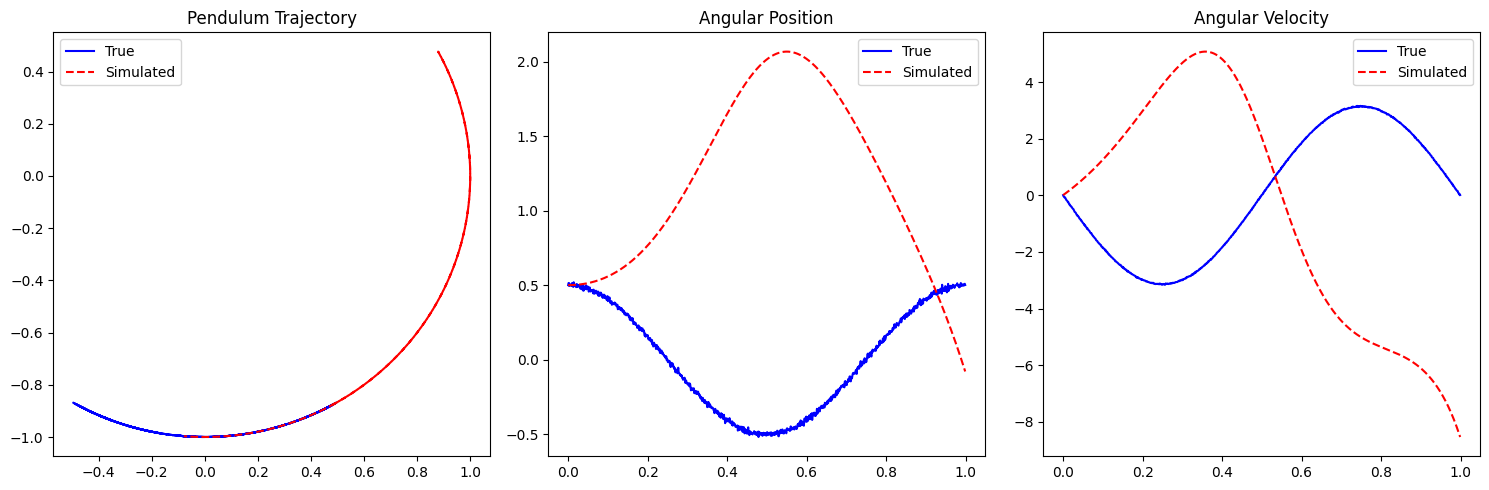

In [22]:
def compute_fvu(y_true, y_pred):
    numerator = torch.sum((y_true - y_pred)**2)
    denominator = torch.sum((y_true - y_true.mean())**2)
    return (numerator / denominator).item()

def simulate_system(model, z0, dz0, t_span, dt):
    t = torch.arange(t_span[0], t_span[1], dt)
    z = torch.zeros(len(t))
    dz = torch.zeros(len(t))
    
    z[0] = z0
    dz[0] = dz0
    
    for i in range(len(t)-1):
        ddz = model.sindy(z[i:i+1], dz[i:i+1])
        z[i+1] = z[i] + dz[i] * dt
        dz[i+1] = dz[i] + ddz * dt
    
    return t, z, dz

# Evaluate the model
model.eval()
with torch.no_grad():
    # Reconstruction evaluation
    x_rec, ddz, z_ddz_pred, x_ddz_pred = model(x, dx, ddx)

    # Compute FVU metrics
    fvu_x = compute_fvu(x, x_rec)
    fvu_ddz = compute_fvu(ddz, z_ddz_pred)
    fvu_ddx = compute_fvu(ddx, x_ddz_pred)

    print(f"FVU x: {fvu_x:.4f}")
    print(f"FVU ddz: {fvu_ddz:.4f}")
    print(f"FVU ddx: {fvu_ddx:.4f}")

    print("\nLearned SINDy coefficients:")
    active_terms = model.sindy.mask * model.sindy.Xi
    print(active_terms.cpu().numpy())

    # Simulate system
    t, z_sim, dz_sim = simulate_system(
        model=model,
        z0=z[0],
        dz0=dz[0],
        t_span=(0, 1),
        dt=0.001
    )

    # Convert simulation to cartesian coordinates
    x_sim, dx_sim, ddx_sim = embed_cartesian(
        z_sim[:, None],
        dz_sim[:, None],
        torch.zeros_like(dz_sim[:, None])  # placeholder for ddz
    )

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot(x[:, 0].cpu(), x[:, 1].cpu(), 'b-', label='True')
    plt.plot(x_sim[:, 0].cpu(), x_sim[:, 1].cpu(), 'r--', label='Simulated')
    plt.title('Pendulum Trajectory')
    plt.legend()

    plt.subplot(132)
    plt.plot(t, z.cpu(), 'b-', label='True')
    plt.plot(t, z_sim.cpu(), 'r--', label='Simulated')
    plt.title('Angular Position')
    plt.legend()

    plt.subplot(133)
    plt.plot(t, dz.cpu(), 'b-', label='True')
    plt.plot(t, dz_sim.cpu(), 'r--', label='Simulated')
    plt.title('Angular Velocity')
    plt.legend()

    plt.tight_layout()
    plt.show()

    